In [ ]:
!pip install -q --pre deepchem
import deepchem
deepchem.__version__

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from collections import OrderedDict

import deepchem as dc
import deepchem.models
from deepchem.models import BasicMolGANModel as MolGAN
from deepchem.models.optimizers import ExponentialDecay
import tensorflow as tf
from tensorflow import one_hot
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

from deepchem.feat.molecule_featurizers.molgan_featurizer import GraphMatrix

In [3]:
tasks, datasets, transformers = dc.molnet.load_tox21()
df = pd.DataFrame(data={'smiles': datasets[0].ids})

[13:13:54] WARNING: not removing hydrogen atom without neighbors
[13:14:05] WARNING: not removing hydrogen atom without neighbors


In [4]:
num_atoms = 15
df

,smiles
0,CC(O)(P(=O)(O)O)P(=O)(O)O
1,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C
2,OC[C@H](O)[C@@H](O)[C@H](O)CO
3,CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2]
4,CC(C)COC(=O)C(C)C
...,...
6259,CC1CCCCN1CCCOC(=O)c1ccc(OC2CCCCC2)cc1
6260,Cc1cc(CCCOc2c(C)cc(-c3noc(C(F)(F)F)n3)cc2C)on1
6261,O=C1OC(OC(=O)c2cccnc2Nc2cccc(C(F)(F)F)c2)c2ccc...
6262,CC(=O)C1(C)CC2=C(CCCC2(C)C)CC1C


In [5]:
# Create featurizer
feat = dc.feat.MolGanFeaturizer(max_atom_count=num_atoms)

# Extract the smiles from the dataframe as a list of strings
smiles = df['smiles'].values

# Filter out the molecules with too many atoms to reduce the number of unnecessary error messages in later steps.
filtered_smiles = [x for x in smiles if Chem.MolFromSmiles(x).GetNumAtoms() < num_atoms]

[13:14:13] WARNING: not removing hydrogen atom without neighbors


In [ ]:
# Featurize molecules
features = feat.featurize(filtered_smiles)

In [7]:
# Remove invalid molecules
indices = [ i for i, data in enumerate(features) if type(data) is GraphMatrix]

print('Number of indicies:', len(indices))
features = [features[i] for i in indices]

Number of indicies: 2107


In [8]:
# Create MolGAN model
gan = MolGAN(learning_rate=ExponentialDecay(0.001, 0.9, 5000), vertices=num_atoms)
dataset = dc.data.NumpyDataset([x.adjacency_matrix for x in features],[x.node_features for x in features])

In [9]:
def iterbatches(epochs):
    for i in range(epochs):
        for batch in dataset.iterbatches(batch_size=gan.batch_size, pad_batches=True):
            adjacency_tensor = one_hot(batch[0], gan.edges)
            node_tensor = one_hot(batch[1], gan.nodes)
            yield {gan.data_inputs[0]: adjacency_tensor, gan.data_inputs[1]:node_tensor}

In [10]:
# Train model
gan.fit_gan(iterbatches(25), generator_steps=0.2, checkpoint_interval=5000)

Ending global_step 549: generator average loss 6.54787, discriminator average loss -24.9391
TIMING: model fitting took 89.168 s


In [ ]:
# Generate 1000 samples
generated_data = gan.predict_gan_generator(1000)
generated_mols = feat.defeaturize(generated_data)

In [12]:
# Check molecule validity (unstable so you might end up with 0 valid molecules)
valid_mols = [x for x in generated_mols if x is not None]
print (f'{len(valid_mols)} valid molecules (out of {len((generated_mols))} generated molecules)')

631 valid molecules (out of 1000 generated molecules)


In [13]:
generated_smiles = [Chem.MolToSmiles(x) for x in valid_mols]
generated_smiles_viz = [Chem.MolFromSmiles(x) for x in set(generated_smiles)]
print(f'{len(generated_smiles_viz)} unique valid molecules ({len(generated_smiles)-len(generated_smiles_viz)} redundant molecules)')

10 unique valid molecules (621 redundant molecules)


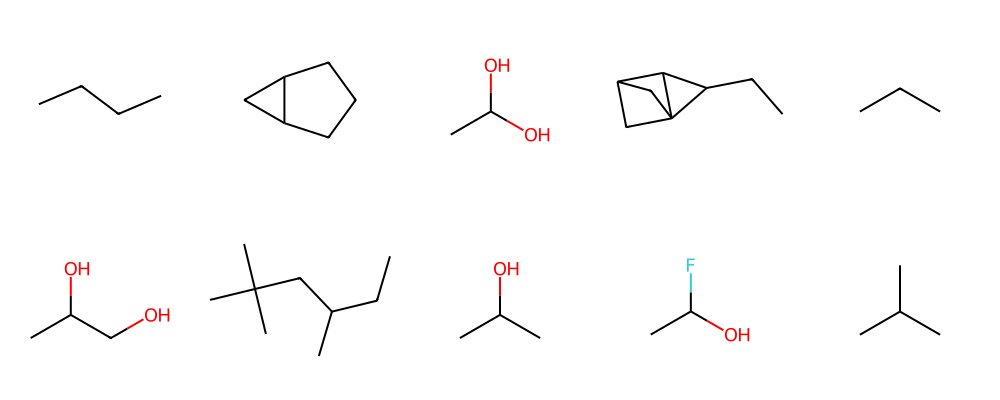

In [14]:
Draw.MolsToGridImage(generated_smiles_viz, molsPerRow=5, subImgSize=(200, 200), returnPNG=False)